#### Diabetes in Embedding Space

Plan - strt by looking at one sick, one healthy patients. Use pandas to join between the seperate files.

In [1]:
cd ..

/home/dsi/rgoldner/projects/cvc


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import collections
import importlib
import matplotlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

SRC_DIR = "cvc"

from child_diabetes_timepoints import diabetes_utils as du
from cvc import embbeding_wrapper as ew
from child_diabetes_timepoints import graph_utils as gu
from cvc import utils
from lab_notebooks.utils import TRANSFORMER, DEVICE, DATA_DIR
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)

FILT_EDIT_DIST = True

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/CDR3_data_plots")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

INFO:matplotlib.font_manager:Failed to extract font properties from /usr/share/fonts/google-noto-emoji/NotoColorEmoji.ttf: In FT2Font: Could not set the fontsize (error code 0x17)


'plots/CDR3_data_plots'

#### Load and Process data

In [4]:
DATA_FOLDER_DIR = "/dsi/scratch/home/dsi/romiDiabetes/"

# combine files according to control/case metadata
case_samples_dir = DATA_FOLDER_DIR + "case_samples.csv"
control_samples_dir = DATA_FOLDER_DIR + "control_samples.csv"

In [5]:
# Process metadata
case_samples = du.process_diabetes_metadata(case_samples_dir)
control_samples = du.process_diabetes_metadata(control_samples_dir)

/home/dsi/rgoldner/anaconda3/envs/tcrbert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3191: DtypeWarning: Columns (0,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if await self.run_code(code, result, async_=asy):
/home/dsi/rgoldner/projects/cvc/child_diabetes_timepoints/diabetes_utils.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  samples['Adaptive ID'] = samples['Adaptive ID'].astype(str).str.replace('\.0', '')
/home/dsi/rgoldner/projects/cvc/child_diabetes_timepoints/diabetes_utils.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  samples['Adaptive ID'] = samples['Adaptive ID'].astype(str).str.replace('\.0', '')


In [225]:
#take out index 12 from case_samples
case_samples = case_samples.drop(12)

In [6]:
# Join data for each patient
cases_dataframes_dict = du.join_data(case_samples[:2], DATA_FOLDER_DIR)
control_dataframes_dict = du.join_data(control_samples[:2], DATA_FOLDER_DIR)

/home/dsi/rgoldner/anaconda3/envs/tcrbert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3191: DtypeWarning: Columns (62) have mixed types.Specify dtype option on import or set low_memory=False.
  if await self.run_code(code, result, async_=asy):
/home/dsi/rgoldner/anaconda3/envs/tcrbert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3191: DtypeWarning: Columns (62) have mixed types.Specify dtype option on import or set low_memory=False.
  if await self.run_code(code, result, async_=asy):
/home/dsi/rgoldner/anaconda3/envs/tcrbert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3191: DtypeWarning: Columns (62) have mixed types.Specify dtype option on import or set low_memory=False.
  if await self.run_code(code, result, async_=asy):
/home/dsi/rgoldner/anaconda3/envs/tcrbert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3191: DtypeWarning: Columns (62) have mixed types.Specify dtype option on import or set low_memory=False.
  if awa

In [7]:
from tqdm import tqdm
# apply the parse_tags function to all dataframes that divides the sample_catalog_tags column into multiple columns
def apply_parse_tags(cases_dataframes_dict):
    for patient_id in tqdm(cases_dataframes_dict.keys()):
        dataframes_list = cases_dataframes_dict[patient_id]
        for i, df in enumerate(dataframes_list):
            dataframes_list[i] = df.join(df['sample_catalog_tags'].apply(du.parse_tags))
            # change cdr3_amino_acid column name to Sequences
            dataframes_list[i].rename(columns={'cdr3_amino_acid': 'Sequences'}, inplace=True)
            # change j_gene column to be all strings
            dataframes_list[i]['j_gene'] = dataframes_list[i]['j_gene'].astype(str)
    return cases_dataframes_dict

cases_dataframes_dict = apply_parse_tags(cases_dataframes_dict)
control_dataframes_dict = apply_parse_tags(control_dataframes_dict)

100%|██████████| 2/2 [02:54<00:00, 87.23s/it]


#### Create and Display embeddings

##### Create embeddings for one patient

In [8]:
from cvc.embbeding_wrapper import EmbeddingWrapper
def create_sample_embeddings(patient_data, TRANSFORMER, DEVICE, batch_size=1024, method="mean", layers=[-1]):
    patient_embeddings_list = []
    for patient_sample_data in patient_data:
        embed_wrap = EmbeddingWrapper(TRANSFORMER, DEVICE, patient_sample_data, batch_size=batch_size, method=method, layers=layers)
        patient_embeddings_list.append(embed_wrap)
    return patient_embeddings_list

In [9]:
def create_all_patient_embeddings(cases_dataframes_dict, TRANSFORMER, DEVICE, batch_size=1024, method="mean", layers=[-1]):
    patient_embeddings_dict = {}
    for key in cases_dataframes_dict.keys():
        patient_embeddings_dict[key] = create_sample_embeddings(cases_dataframes_dict[key], TRANSFORMER, DEVICE, batch_size, method, layers)
    return patient_embeddings_dict

In [10]:
case_patient_embeddings_dict = create_all_patient_embeddings(cases_dataframes_dict, TRANSFORMER, DEVICE)

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

In [11]:
control_patient_embeddings_dict = create_all_patient_embeddings(control_dataframes_dict, TRANSFORMER, DEVICE)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

#### Embeddings Analysis

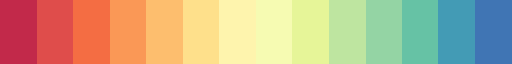

In [174]:
color_label = 'j_gene'
# Create colormap type 1
color_map = ListedColormap(sns.color_palette("rocket", len(tcrb_embeddings_adata.obs[color_label].unique())))

# Create colormap type 2
color_map = ListedColormap(sns.color_palette("Spectral", len(tcrb_embeddings_adata.obs[color_label].unique())))
color_map

In [175]:
color_label = 'j_gene' #'Age
title = "UMAP of Embeddings, Colored by " + color_label
cmap_colors = color_map
pdf_title = "umap_sequence_length.pdf"

##### Patient 0 Embeddings

/home/dsi/rgoldner/anaconda3/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


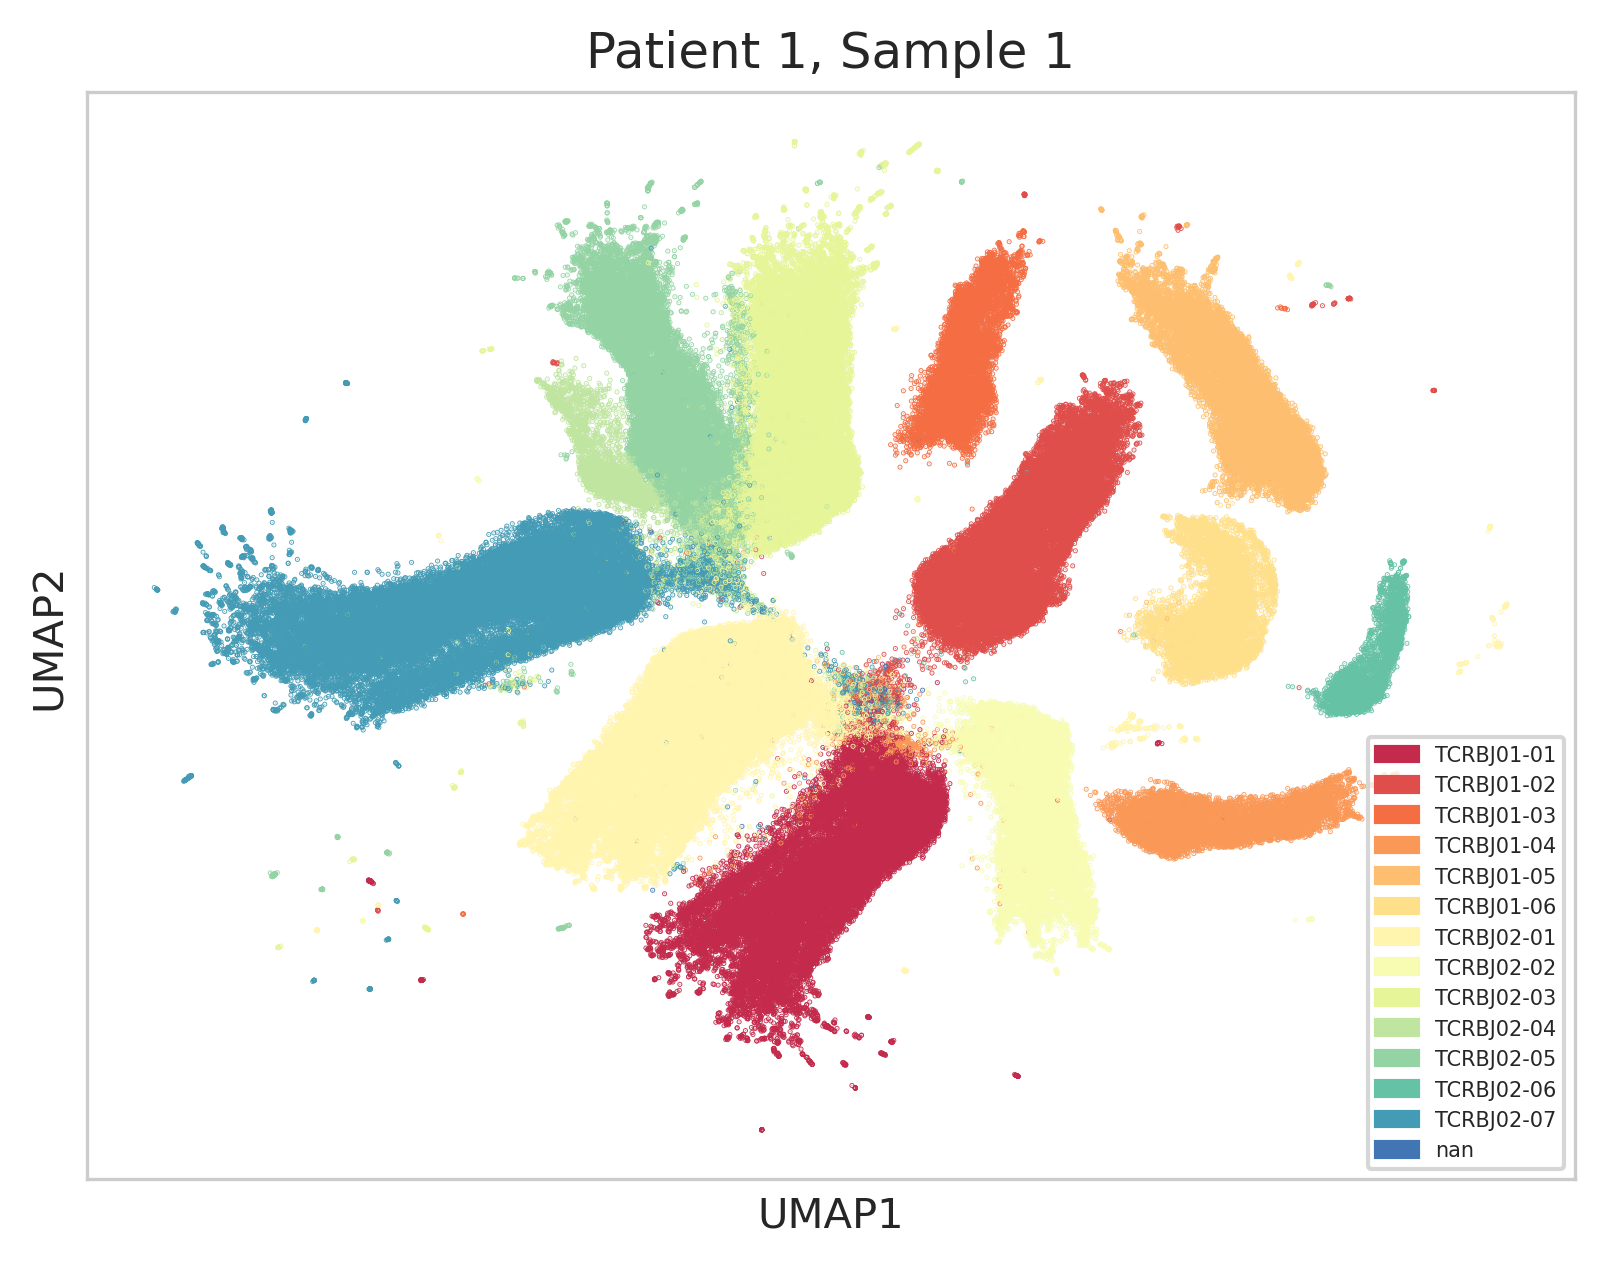

/home/dsi/rgoldner/anaconda3/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


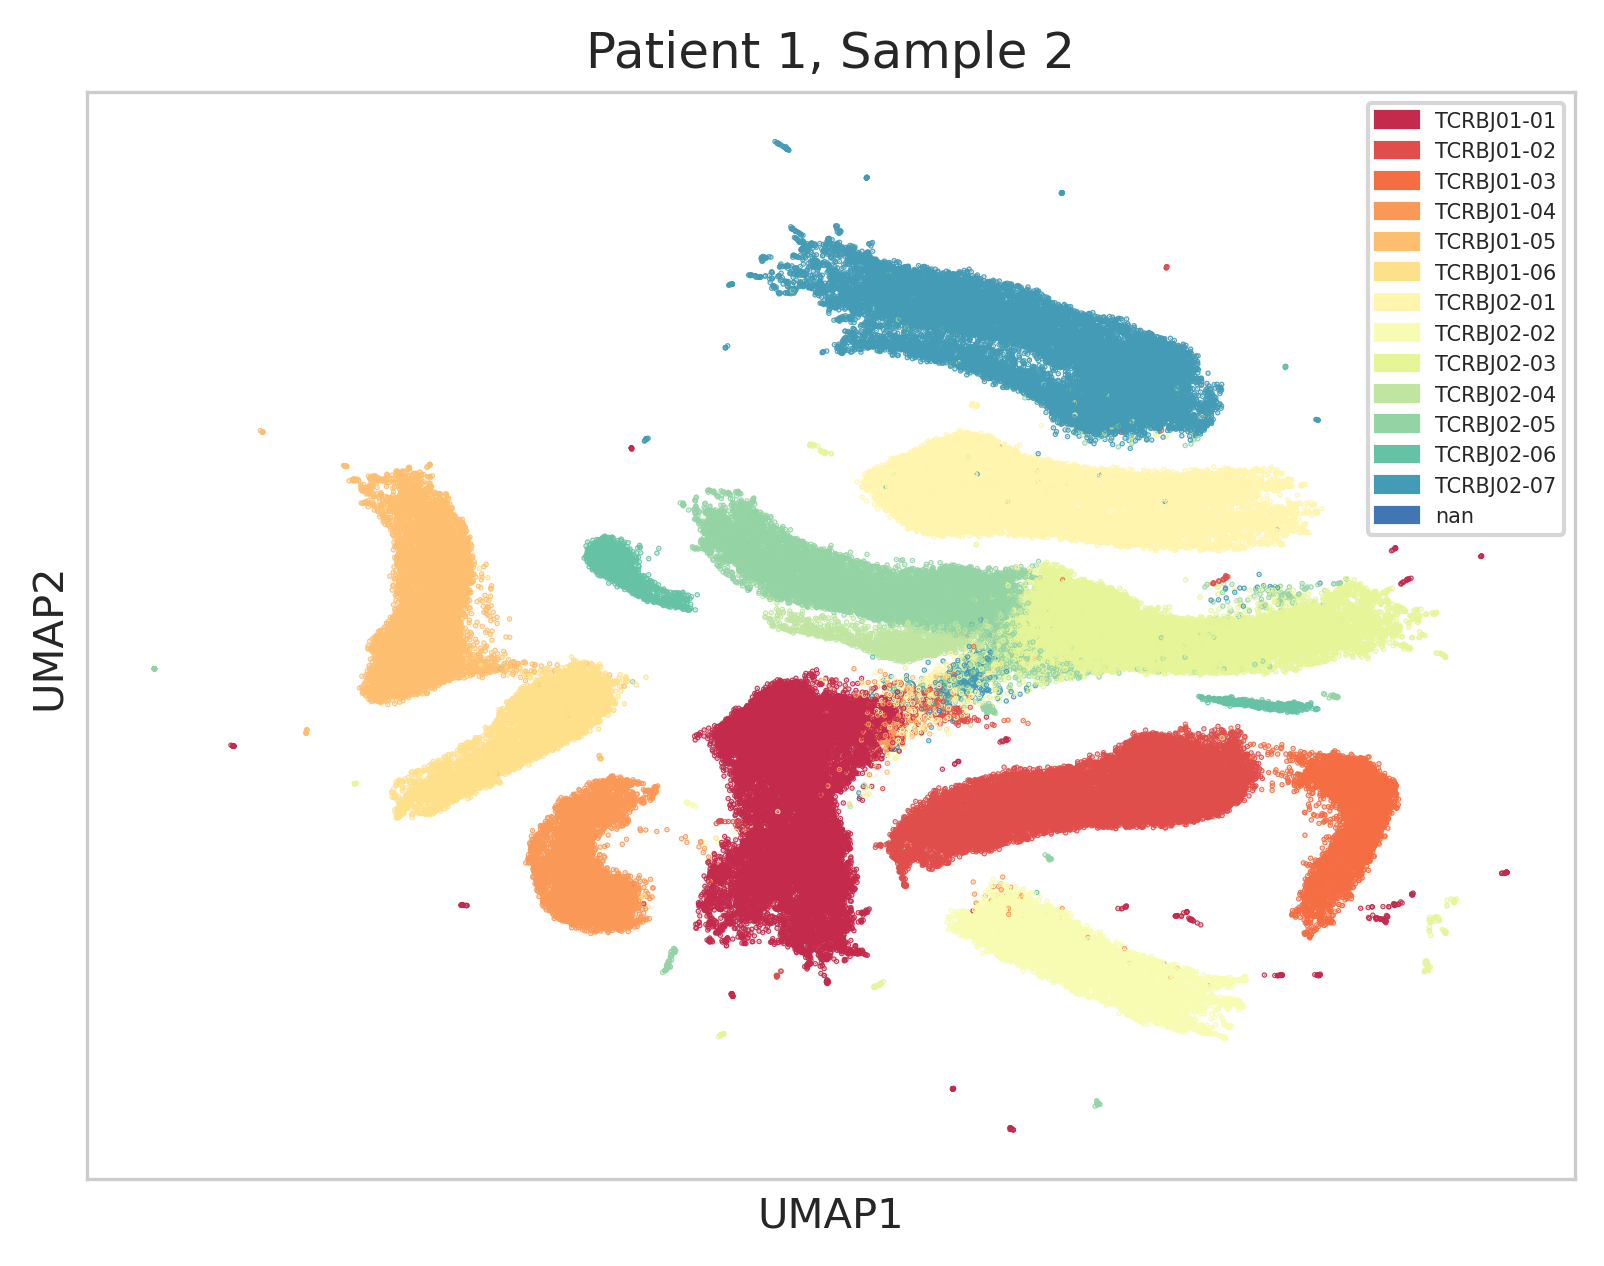

/home/dsi/rgoldner/anaconda3/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


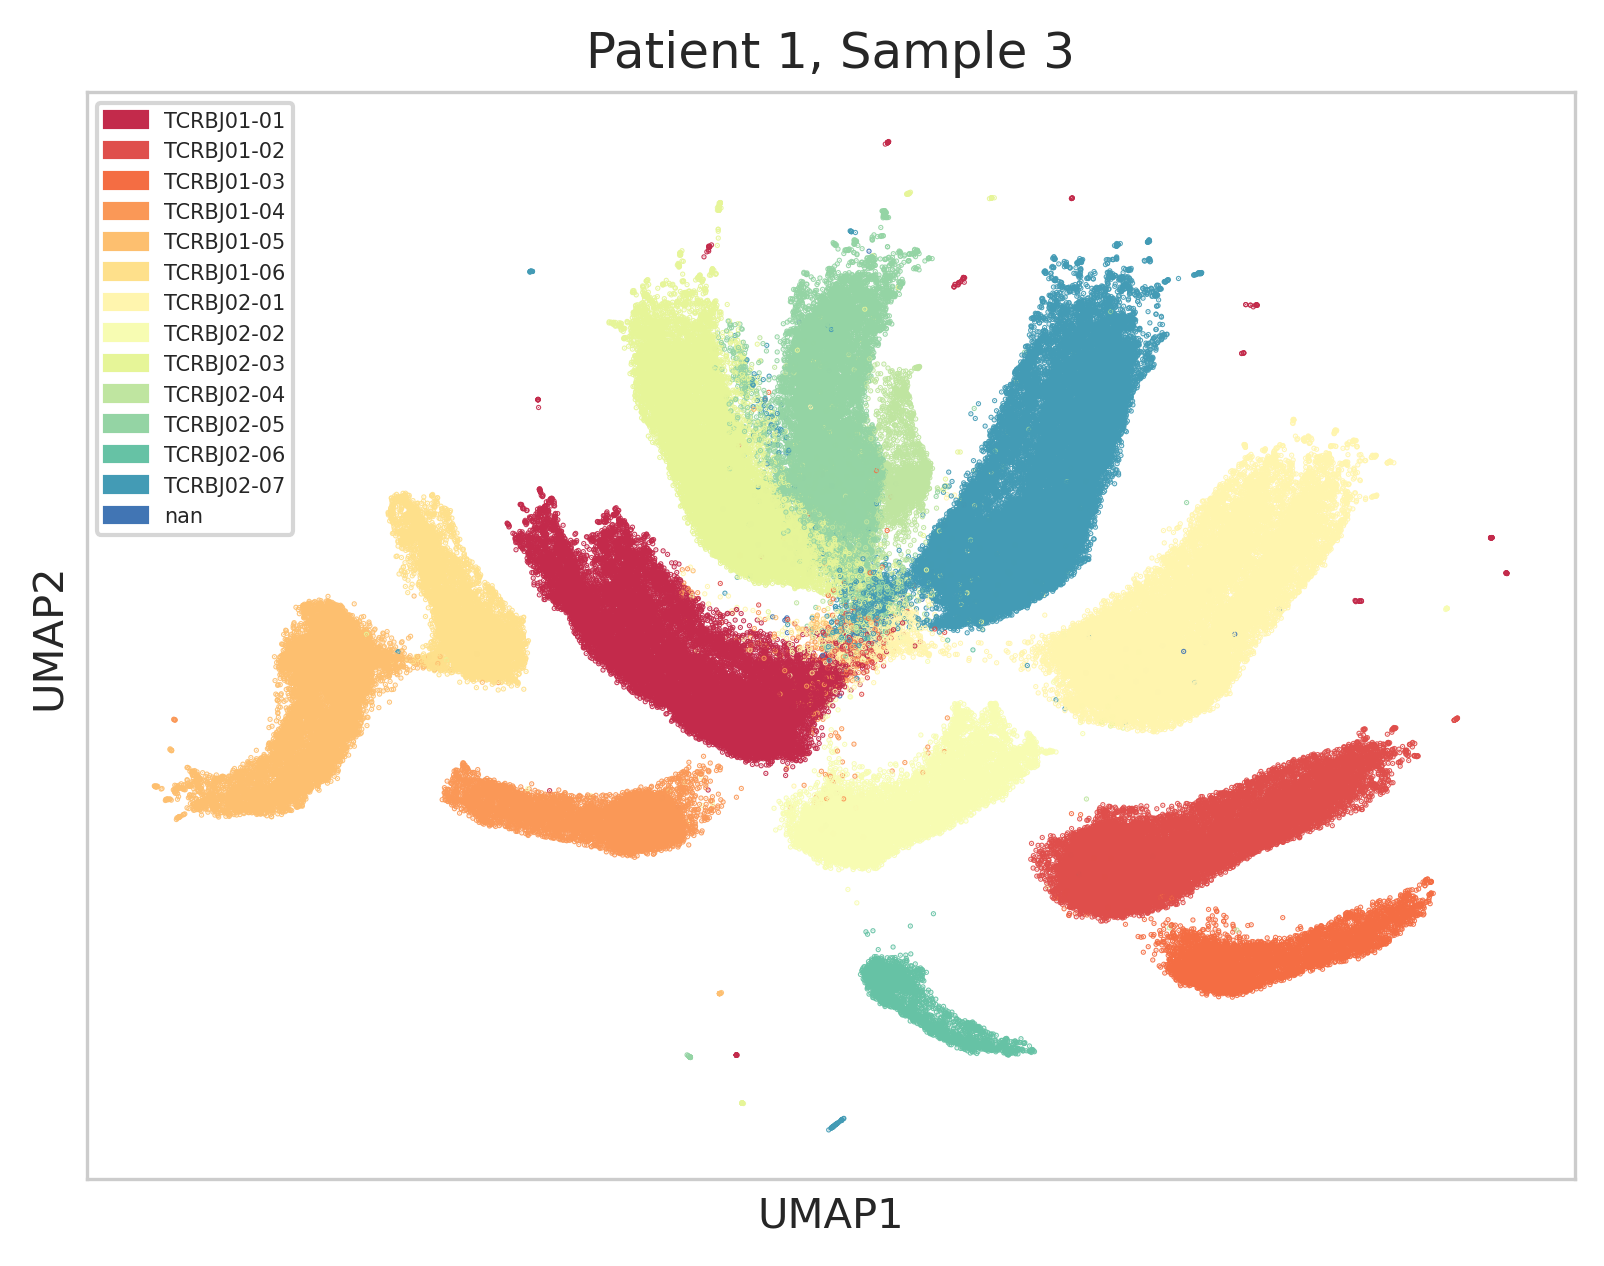

/home/dsi/rgoldner/anaconda3/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


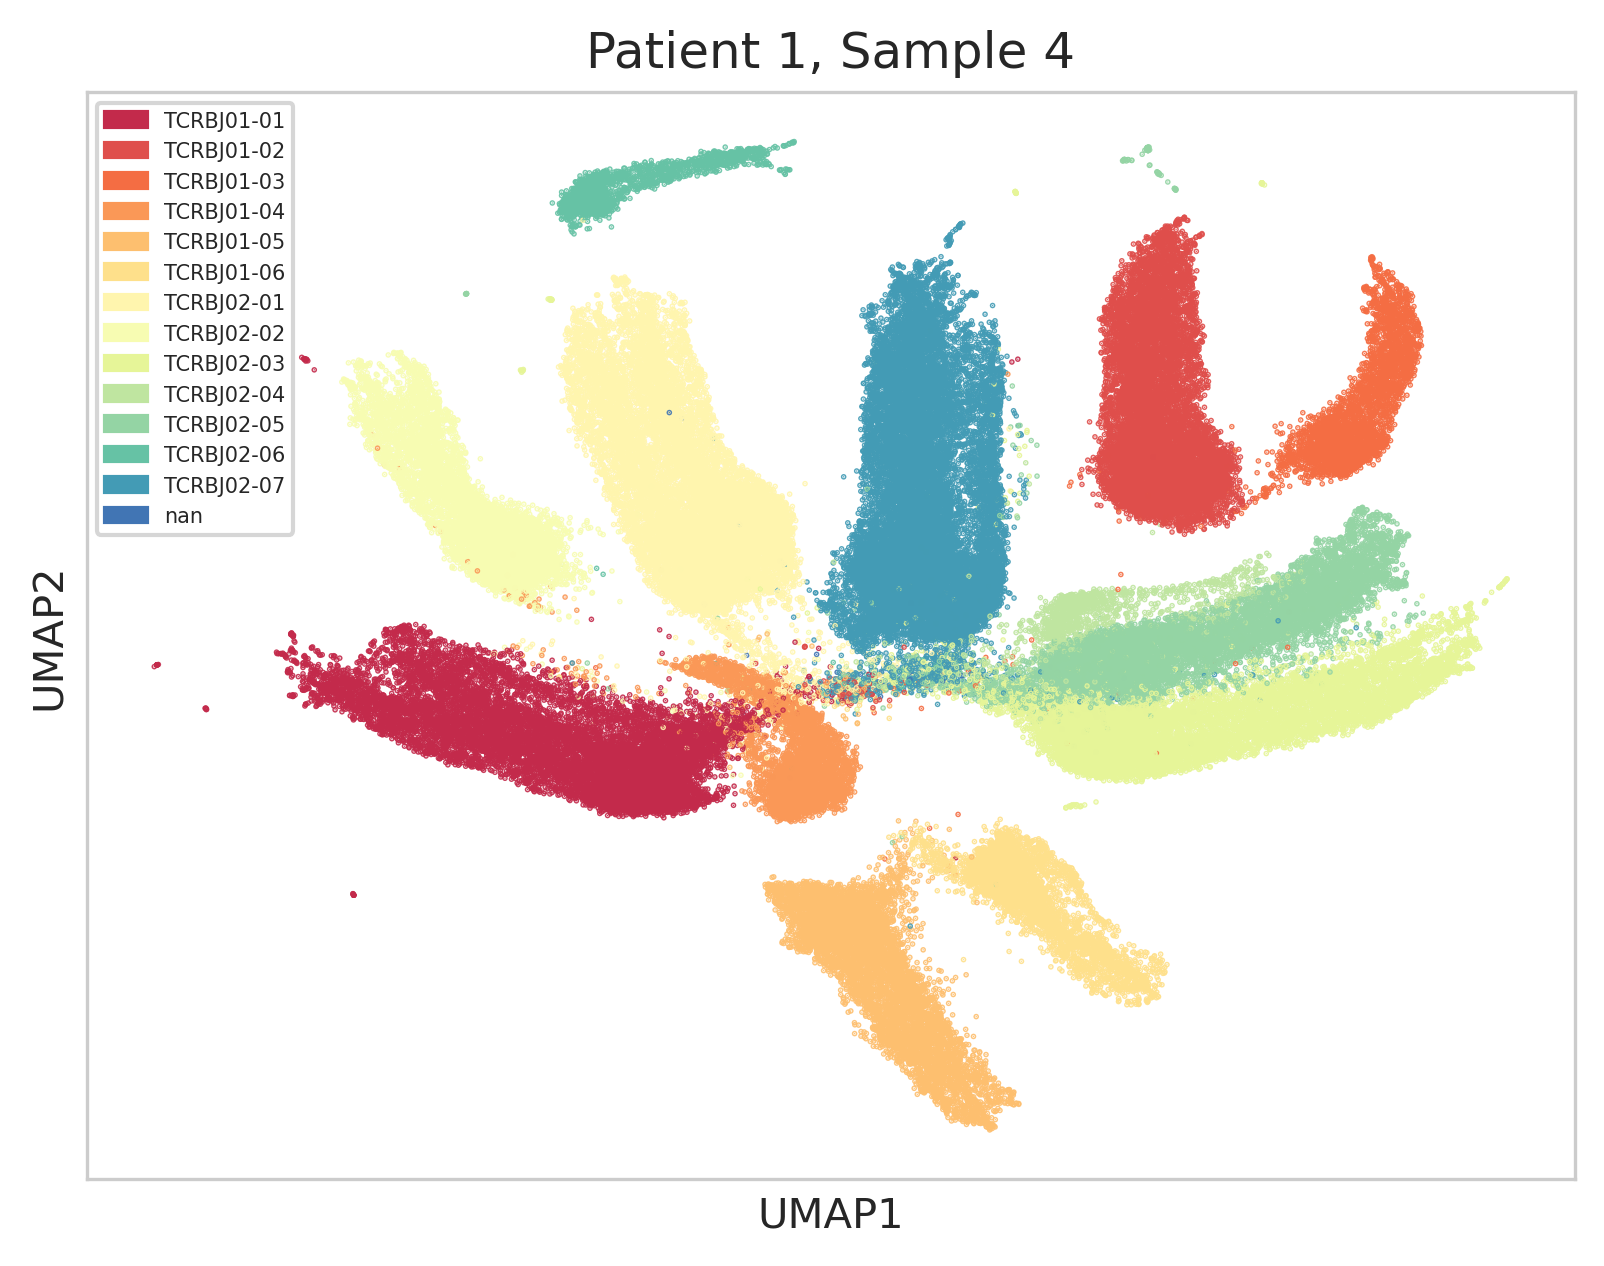

In [184]:
np.random.seed(42)
patient_idx = 1
for i, embeddings in enumerate(case_patient_embeddings_dict[patient_idx][0:4]):
    # Assuming embeddings is an instance of EmbeddingWrapper or similar that has a sequences_df attribute
    # embeddings.sequences_df.sort_values(by=color_label, inplace=True,  ascending=True)

    title = f"Patient {patient_idx}, Sample {i+1}"  # Create a title for each plot
    pdf_title = f"Patient {patient_idx}, Sample_{i+1}_embeddings.pdf"  # Create a unique filename for each plot

    embeddings.plot_embedding(
        color_embed=color_label,
        color_map=cmap_colors,
        title=title,
        legend_size=5,
        plot_pdf_path=os.path.join(PLOT_DIR, pdf_title),
    )

##### Control 0 Embeddings

/home/dsi/rgoldner/anaconda3/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


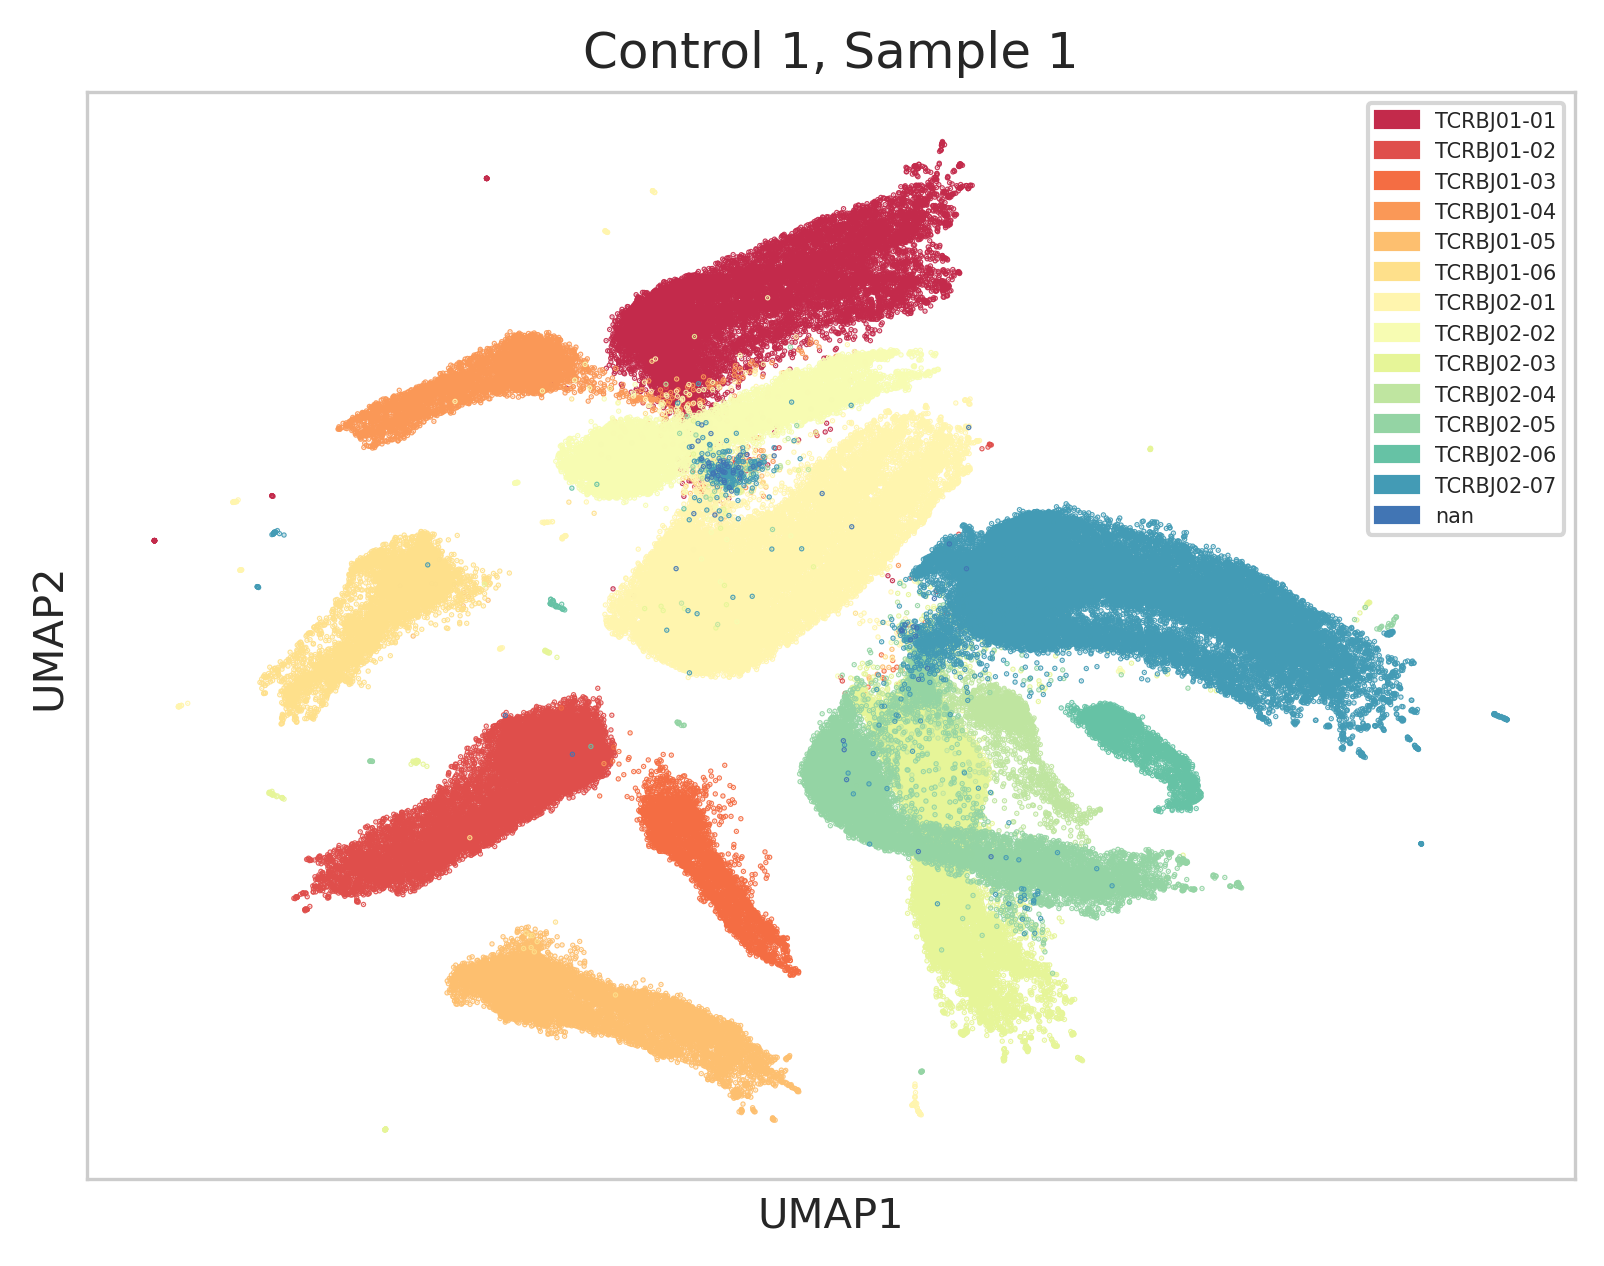

/home/dsi/rgoldner/anaconda3/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


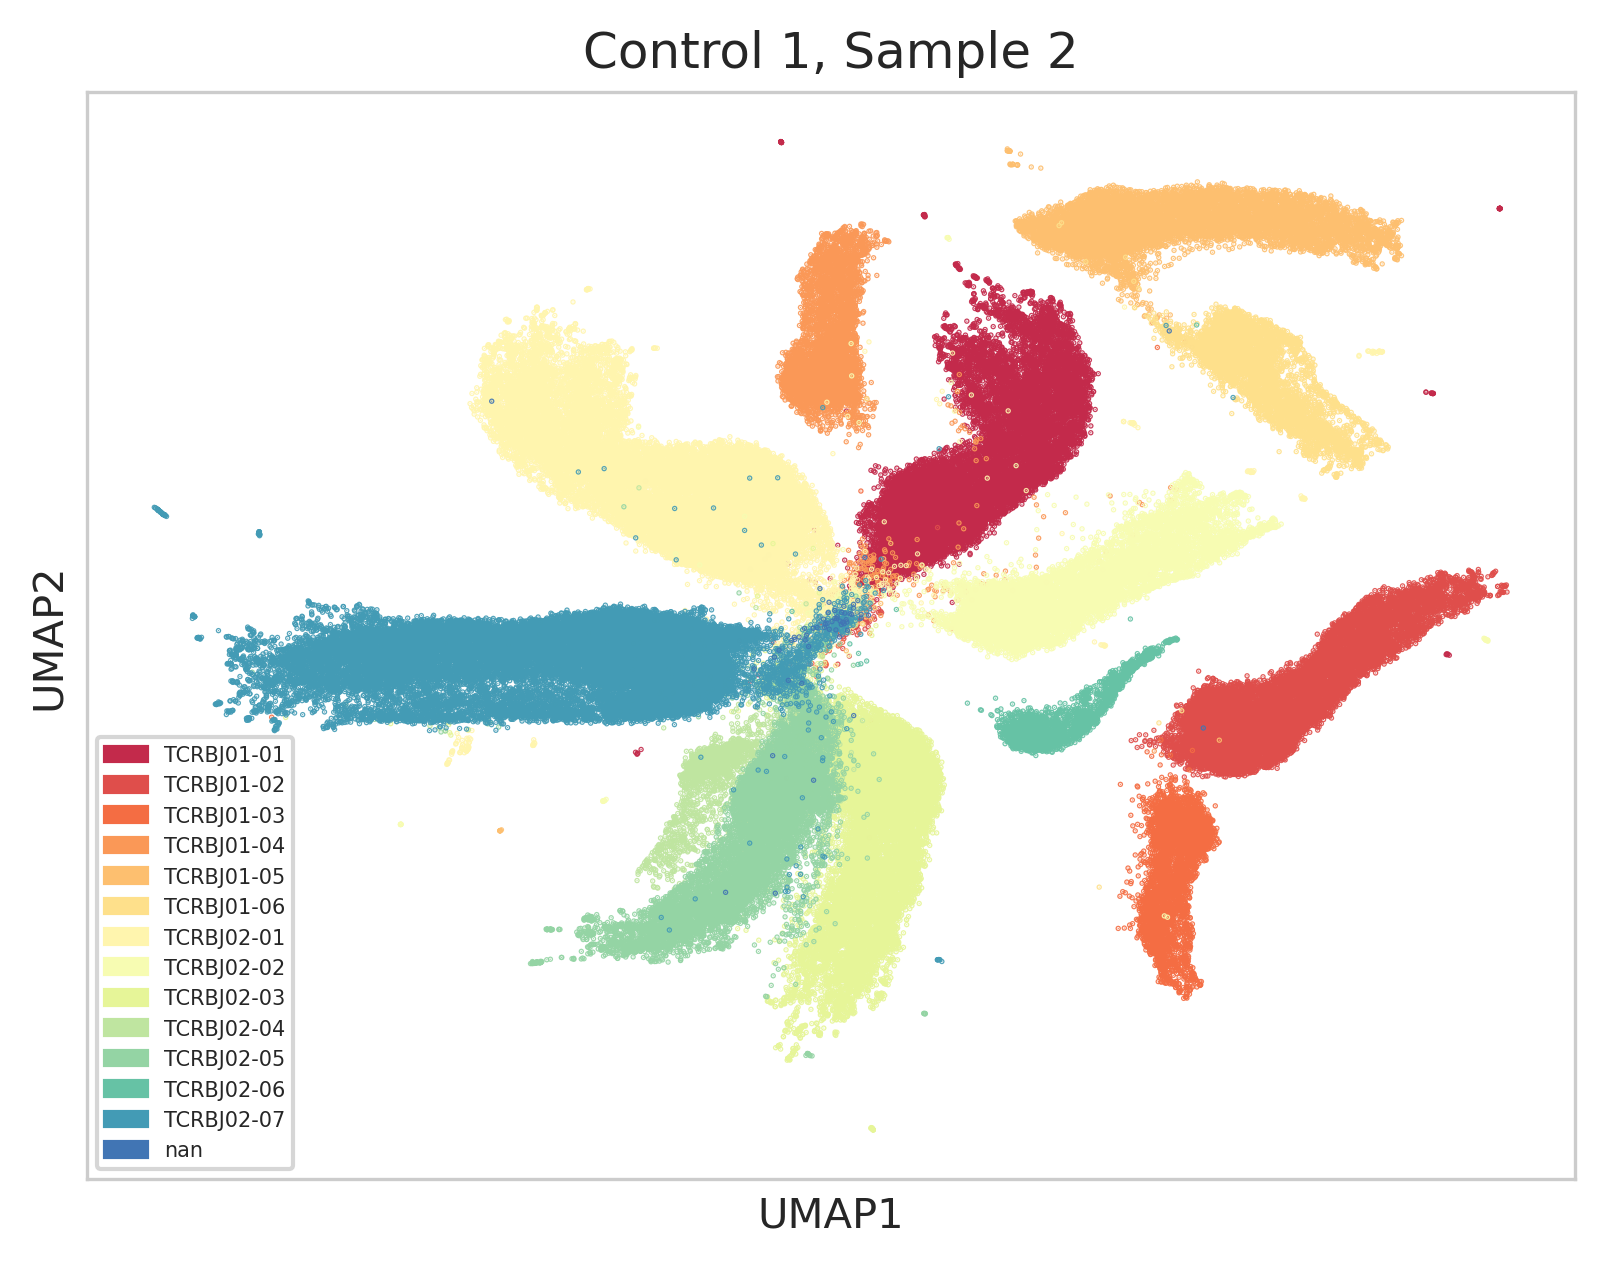

/home/dsi/rgoldner/anaconda3/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


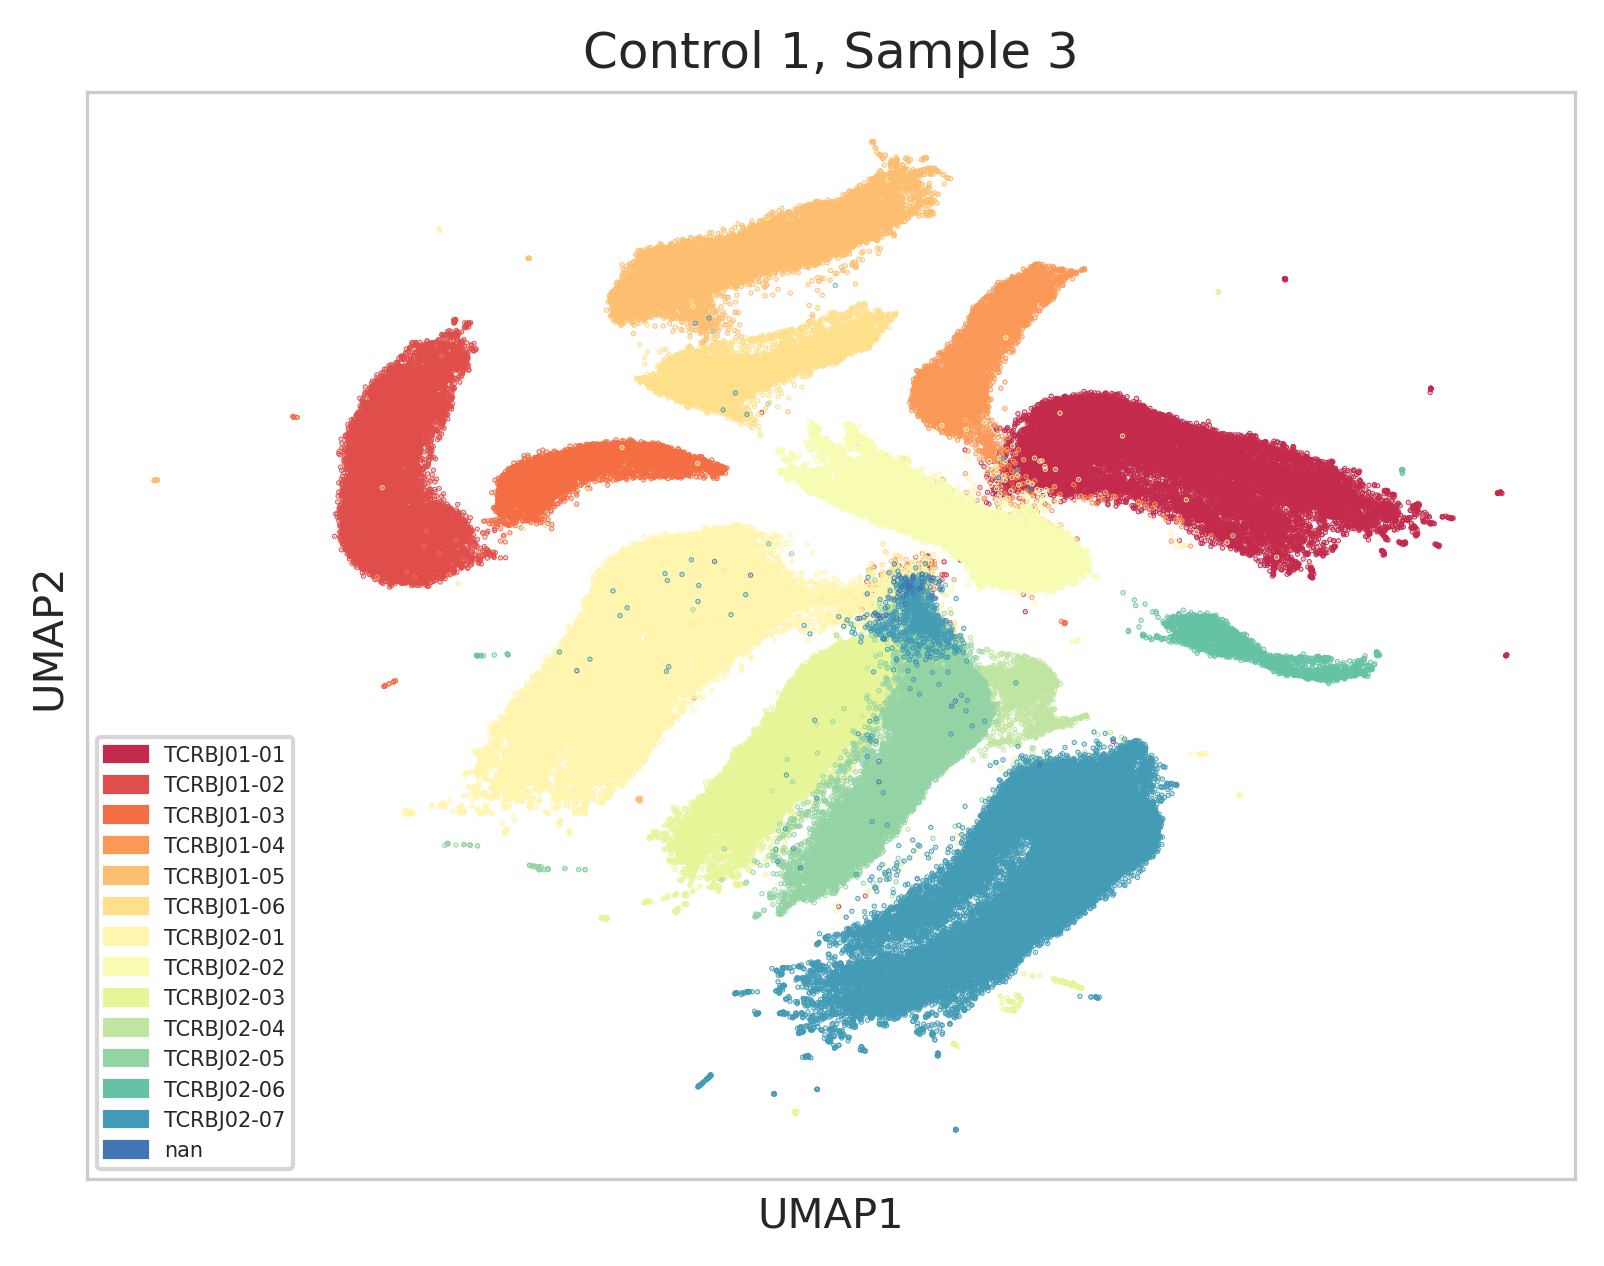

/home/dsi/rgoldner/anaconda3/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


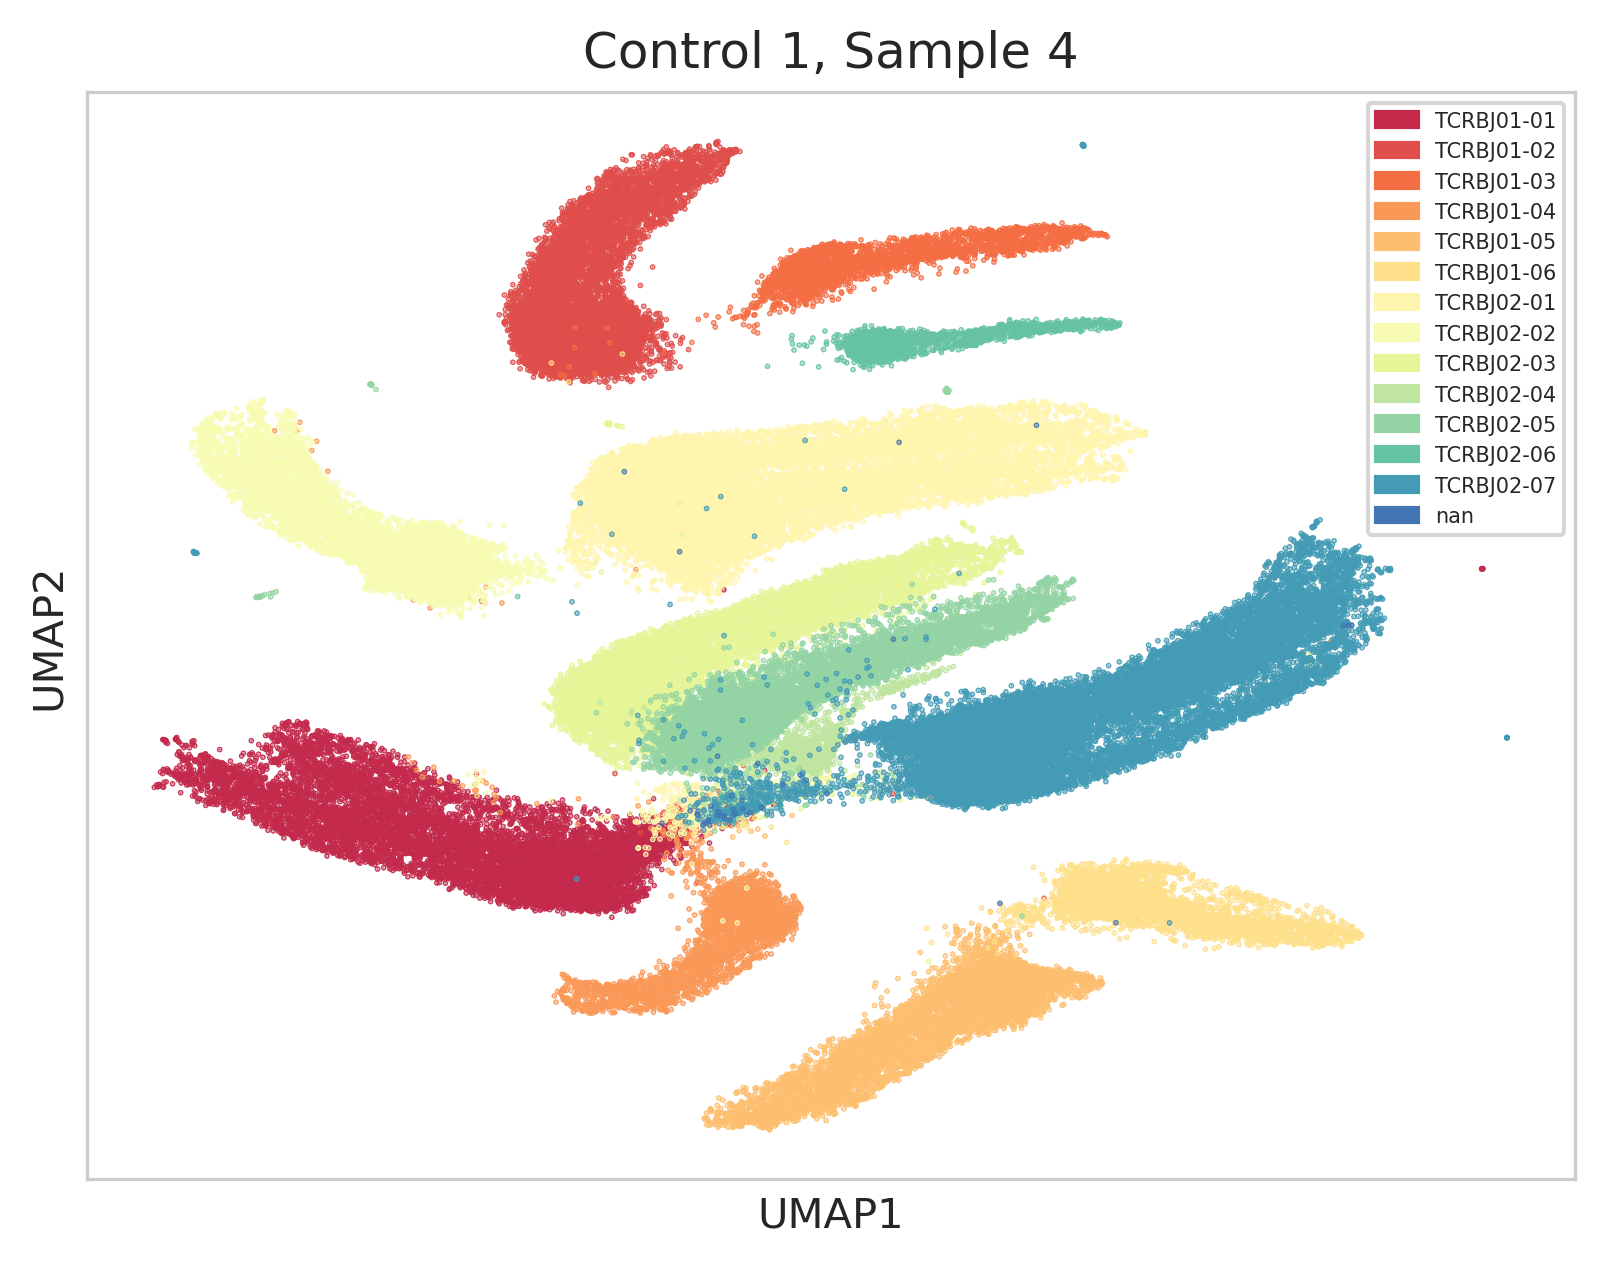

In [186]:
np.random.seed(42)
cotrol_idx = 1
for i, embeddings in enumerate(control_patient_embeddings_dict[cotrol_idx][0:4]):
    # Assuming embeddings is an instance of EmbeddingWrapper or similar that has a sequences_df attribute
    # embeddings.sequences_df.sort_values(by=color_label, inplace=True,  ascending=True)

    title = f"Control {patient_idx}, Sample {i+1}"  # Create a title for each plot
    pdf_title = f"Control {patient_idx}, Sample_{i+1}_embeddings.pdf"  # Create a unique filename for each plot

    embeddings.plot_embedding(
        color_embed=color_label,
        color_map=cmap_colors,
        title=title,
        legend_size=5,
        plot_pdf_path=os.path.join(PLOT_DIR, pdf_title),
    )

#### Embeddings Analysis (and dimensionality reduction)

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
def plot_PCA(patient_data):
    pca = PCA().fit(patient_data.embeddings)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.show()

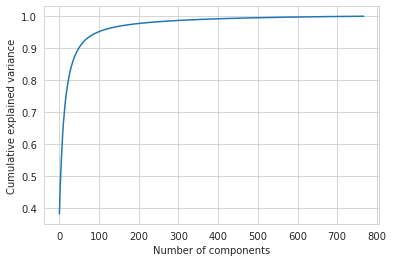

In [38]:
# plot_PCA(case_patient_embeddings_dict[0][0])
# plot_PCA(case_patient_embeddings_dict[1][0])
plot_PCA(case_patient_embeddings_dict[2][0])

From the plots above it makes sense to reduce the dimensionality from 768 to 200

#### Graph Analysis

##### Reduce Dimensionality of Embeddings

In [12]:
# Suppose embeddings is your original data
patient_data = case_patient_embeddings_dict[0][0]
original_embeddings = case_patient_embeddings_dict[0][0].embeddings

##### Create Graph

##### Plot Graph

In [ ]:
sequences = patient_data.sequences_df['Sequences'].tolist()
G = gu.faiss_to_networkx(patient_sample_0_graph_faiss, sequences)

In [68]:
import networkx as nx
import plotly.graph_objects as go

# Position nodes using the Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(G)

# Create edge trace
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Create node trace
node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

# Color node points by the number of connections
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(f'Node {node} has {len(adjacencies[1])} connections')

node_trace.marker.color = node_adjacencies
node_text = [d['sequence'] for _, d in G.nodes(data=True)]
node_trace.text = node_text

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Networkx and Plotly Interactive Graph',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        text="Networkx and Plotly Interactive Graph",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002 ) ],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

# Show the figure
fig.show()

##### Graph Analysis - Cases

In [242]:
GRAPH_DIR = "/dsi/scratch/home/dsi/romiDiabetes/graphs_dir"

In [37]:
case_graph_results_df = gu.process_patient_embeddings(case_patient_embeddings_dict, cases_dataframes_dict, 'case_patient_embeddings_dict', GRAPH_DIR=GRAPH_DIR,calculate_node_metrics=False)

Processing patients: 100%|██████████| 2/2 [13:08<00:00, 394.12s/it]


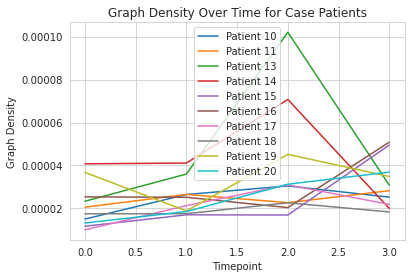

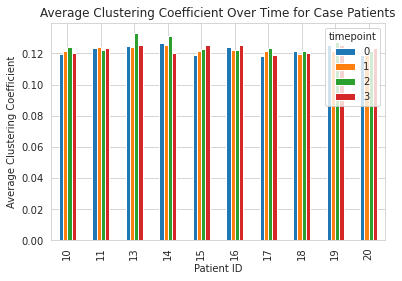

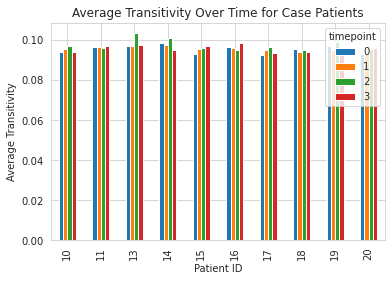

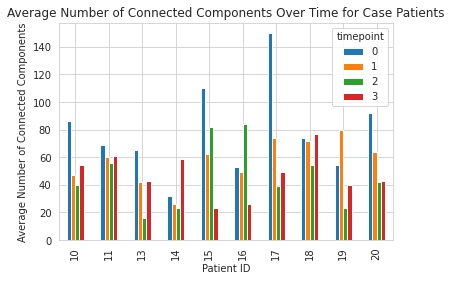

In [239]:
gu.plot_metrics(case_graph_results_df[0], "Case_graph_results_df")

In [38]:
control_graph_results_df = gu.process_patient_embeddings(control_patient_embeddings_dict, control_dataframes_dict, 'control_patient_embeddings_dict', GRAPH_DIR=GRAPH_DIR, calculate_node_metrics=False)

Processing patients: 100%|██████████| 2/2 [11:32<00:00, 346.07s/it]


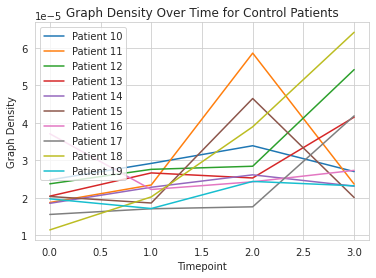

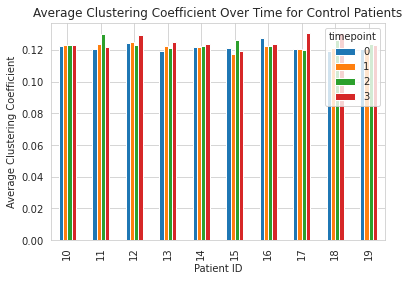

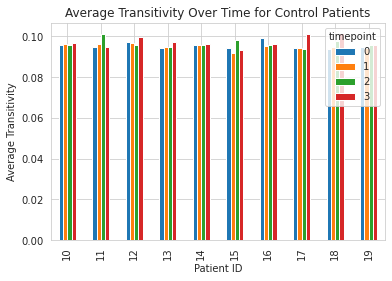

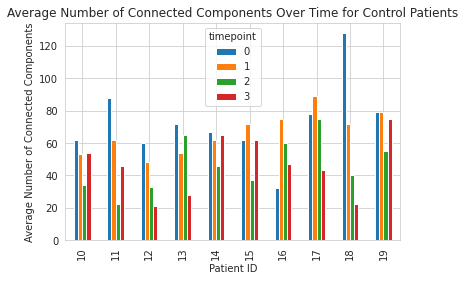

In [240]:
gu.plot_metrics(control_graph_results_df[0], "Control_graph_results_df")

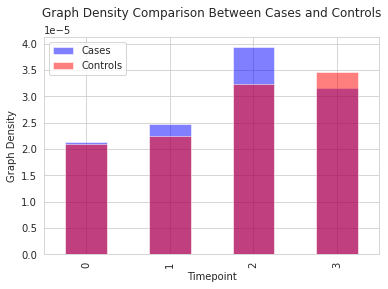

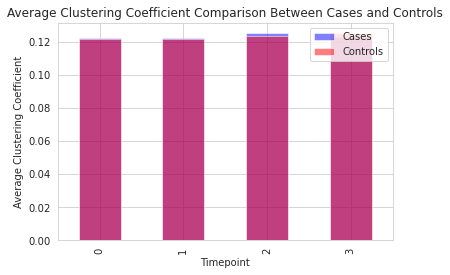

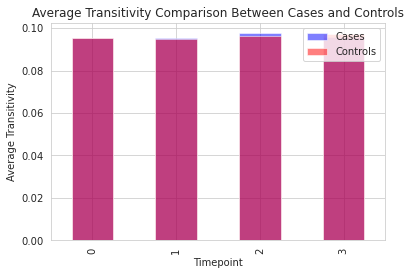

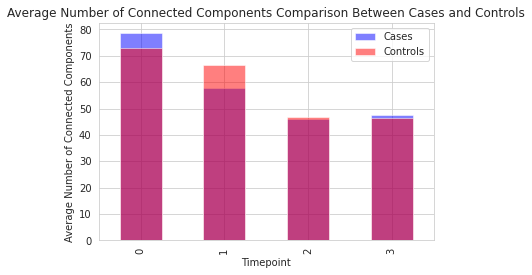

In [241]:
# compare cases and controls metrics at each timepoint
# density comparison
case_graph_results_df[0].groupby(['timepoint'])['density'].mean().plot(kind='bar', color='blue', alpha=0.5, label='Cases')
control_graph_results_df[0].groupby(['timepoint'])['density'].mean().plot(kind='bar', color='red', alpha=0.5, label='Controls')
plt.xlabel('Timepoint')
plt.ylabel('Graph Density')
plt.legend()
plt.title('Graph Density Comparison Between Cases and Controls', pad=20)
plt.show()

# clustering coefficient comparison
case_graph_results_df[0].groupby(['timepoint'])['clustering_coefficient'].mean().plot(kind='bar', color='blue', alpha=0.5, label='Cases')
control_graph_results_df[0].groupby(['timepoint'])['clustering_coefficient'].mean().plot(kind='bar', color='red', alpha=0.5, label='Controls')
plt.xlabel('Timepoint')
plt.ylabel('Average Clustering Coefficient')
plt.legend()
plt.title('Average Clustering Coefficient Comparison Between Cases and Controls')
plt.show()

# transitivity comparison
case_graph_results_df[0].groupby(['timepoint'])['transitivity'].mean().plot(kind='bar', color='blue', alpha=0.5, label='Cases')
control_graph_results_df[0].groupby(['timepoint'])['transitivity'].mean().plot(kind='bar', color='red', alpha=0.5, label='Controls')
plt.xlabel('Timepoint')
plt.ylabel('Average Transitivity')
plt.legend()
plt.title('Average Transitivity Comparison Between Cases and Controls')
plt.show()

# connected components comparison
case_graph_results_df[0].groupby(['timepoint'])['connected_components'].mean().plot(kind='bar', color='blue', alpha=0.5, label='Cases')
control_graph_results_df[0].groupby(['timepoint'])['connected_components'].mean().plot(kind='bar', color='red', alpha=0.5, label='Controls')
plt.xlabel('Timepoint')
plt.ylabel('Average Number of Connected Components')
plt.legend()
plt.title('Average Number of Connected Components Comparison Between Cases and Controls')

plt.show()
